## Import library

In [8]:
import numpy as np
import os
import gc
import pandas as pd
import seaborn as sns
import imagehash
from pathlib import Path
from glob import glob # parse the files name
from PIL import Image
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from subprocess import check_output

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as k
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import multi_gpu_model
from keras.applications import VGG16
from keras.callbacks import TensorBoard

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_pywrap_tensorflow_internal /usr/local/lib/python3.5/dist-packages/tensorflow/python/_pywrap_tensorflow_internal.so


In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
#os.environ["CUDA_VISIBLE_DEVICES"] = 0,1 #  '':表示強迫使用cpu

## Set data path

In [3]:
main_path = Path('../../../data/humpback-whale-identification-challenge')
train_path = main_path / 'train'
test_path = main_path / 'test'
train_images = glob(str(train_path / '*.jpg'))
test_image = glob(str(test_path / '*.jpg'))
df = pd.read_csv(str(main_path / 'train.csv'))

In [4]:
print('Number of train images: {}\nNumber of test images: {}'.format(
    len(train_images), len(test_image)))

Number of train images: 9850
Number of test images: 15610


# Data Clean
* Duplicate Images (要針對image的內容來看)


In [5]:
df['Image'] = df['Image'].map(lambda x: str(train_path / x))
ImageToLabelDict = dict(zip(df['Image'], df['Id']))

In [17]:
df[df.Id == 'w_6384242']

,Image,Id
4821,../../../data/humpback-whale-identification-ch...,w_6384242


In [30]:
def getImageMetaData(file_path):
    with Image.open(file_path) as img:
        img_hash = imagehash.phash(img)
        return img.size, img.mode, img_hash

m = df['Image'].apply(lambda x: getImageMetaData(x))

In [34]:
m.head()

0       ((699, 500), L, b362cc79b1a623b8)
1    ((1050, 700), RGB, b3cccc3331cc8733)
2    ((1050, 368), RGB, bc4ed0f2a7e168a8)
3     ((397, 170), RGB, 93742d9a28b35b87)
4       ((700, 398), L, d4a1dab1c49f6352)
Name: Image, dtype: object

In [37]:
df['Hash'] = [str(i[2]) for i in m]
df['Shape'] = [i[0] for i in m]
df['Mode'] = [str(i[1]) for i in m]
df['Length'] = df['Shape'].apply(lambda x: x[0]*x[1])
df['Ratio'] = df['Shape'].apply(lambda x: x[0]/x[1])
df['isNewWhale'] = df['Id'] == 'new_whale'

In [39]:
df.head()

,Image,Id,Hash,Shape,Mode,Length,Ratio,isNewWhale
0,../../../data/humpback-whale-identification-ch...,w_e15442c,b362cc79b1a623b8,"(699, 500)",L,349500,1.398000,False
1,../../../data/humpback-whale-identification-ch...,w_1287fbc,b3cccc3331cc8733,"(1050, 700)",RGB,735000,1.500000,False
2,../../../data/humpback-whale-identification-ch...,w_da2efe0,bc4ed0f2a7e168a8,"(1050, 368)",RGB,386400,2.853261,False
3,../../../data/humpback-whale-identification-ch...,w_19e5482,93742d9a28b35b87,"(397, 170)",RGB,67490,2.335294,False
4,../../../data/humpback-whale-identification-ch...,w_f22f3e3,d4a1dab1c49f6352,"(700, 398)",L,278600,1.758794,False


In [40]:
hash_image_count = df['Hash'].value_counts()

In [44]:
t = hash_image_count.loc[hash_image_count>1]
print("There are {} duplicate images.".format(np.sum(t)-len(t)))
t.head()

There are 778 duplicate images.


bb8ec43039cb663c    3
bfc2b065a97c8b12    2
f6091d1b96a6a1f4    2
e19ac6699a86e559    2
b84ed2b6a5b1ee80    2
Name: Hash, dtype: int64

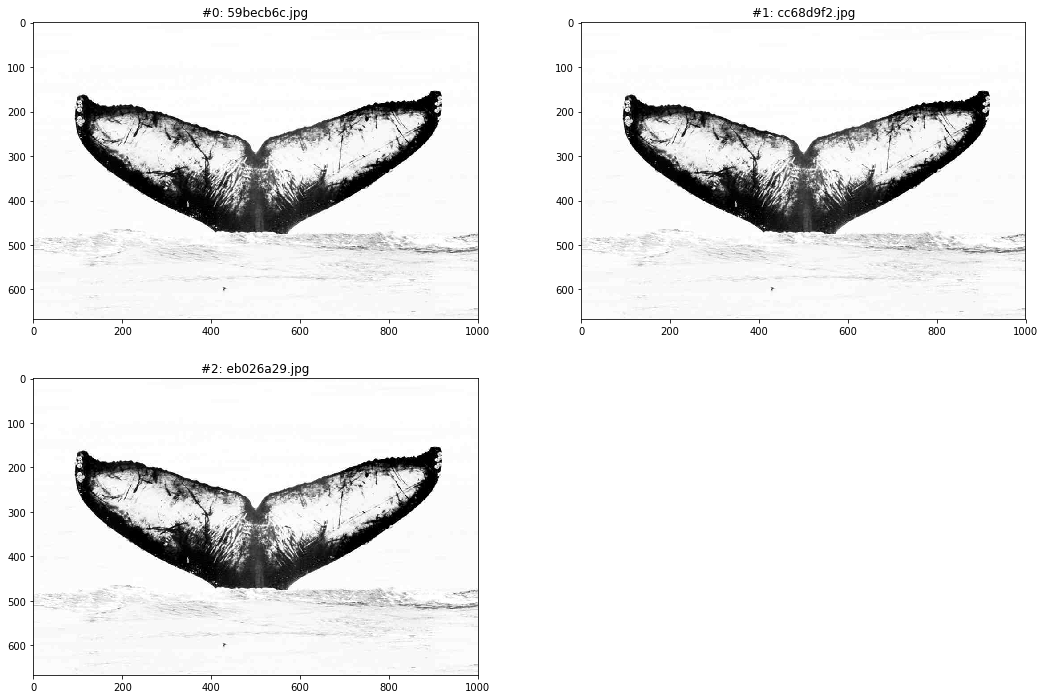

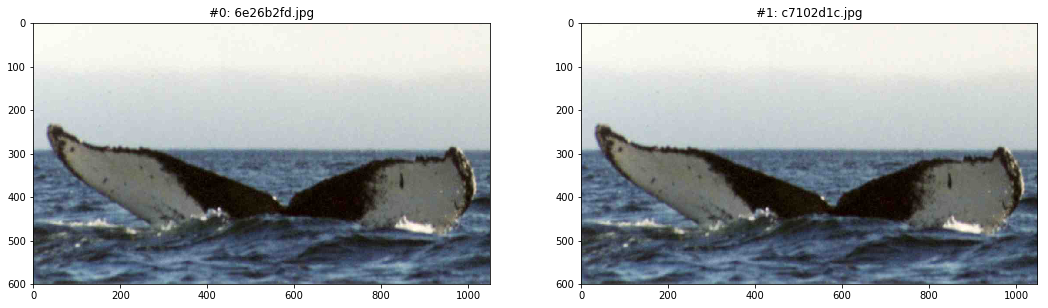

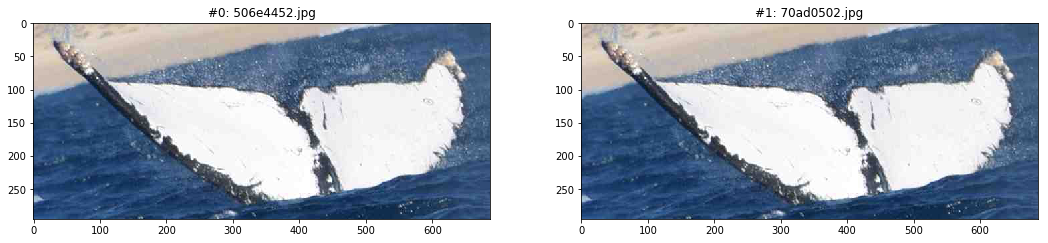

In [105]:
import collections
import re
def plot_duplicate_image(imgs):
    assert(isinstance(imgs, collections.Iterable))
    imgs_list = list(imgs)
    nrows = len(imgs_list)
    if (nrows % 2 != 0):
        nrows = nrows + 1
    plt.figure(figsize=(18, 6*nrows/2)) # 目的是讓圖的寬度相等呈現
    for i, img_file in enumerate(imgs_list):
        with Image.open(img_file) as img:
            ax = plt.subplot(nrows/2, 2, i+1)
            img_id = re.search('[\w\d]+(.)\w+$', img_file)
            ax.set_title('#{}: {}'.format(i, img_id.group(0)))
            ax.imshow(img)

plot_duplicate_image(df[df['Hash']==t.index[0]].Image)            
plot_duplicate_image(df[df['Hash']==t.index[3]].Image)   
plot_duplicate_image(df[df['Hash']==t.index[8]].Image)

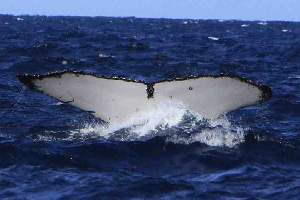

In [113]:
#from IPython.display import Image
#Image.open(filename=df['Image'][0], width=600) 
img = image.load_img(df[df.Id == 'w_6384242']['Image'].values[0], target_size=(200, 300))
img

In [108]:
im = Image.open(df['Image'][4821])
print(im.format, im.size, im.mode)

JPEG (1050, 525) RGB


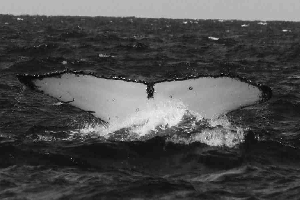

In [112]:
img = Image.open(df['Image'][4821]).convert('LA').resize((300, 200))
img

In [8]:
SIZE = 100
# 這邊將圖原本是RGB的channel轉成L(Binary) channel
# image are imported with a resizing and a black and white conversion
def ImportImage(files):
    img = Image.open(files).convert('LA').resize((SIZE, SIZE))
    return np.array(img)[:, :, 0] # 因為圖片轉為黑白，所以只取channel one
train_img = np.array([ImportImage(img) for img in train_images])
x = train_img
x.shape

(9850, 100, 100)

In [40]:
df['Id'].value_counts()

new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
w_693c9ee     22
w_ab4cae2     22
w_fd1cb9d     22
w_73d5489     21
w_987a36f     21
w_43be268     21
w_f19faeb     20
w_95874a5     19
w_9b401eb     19
w_c0d494d     18
w_b7d5069     18
w_18eee6e     17
w_eb0a6ed     17
w_0e737d0     17
w_dbda0d6     17
w_6c803bf     16
w_b0e05b1     16
w_a59905f     16
w_67de30b     16
w_17ee910     16
w_9ca943b     15
w_89e159a     15
w_ee17a08     15
w_cae7677     15
w_8c1ec28     14
            ... 
w_d521332      1
w_f544197      1
w_83b5e33      1
w_4f0b7d9      1
w_2bb8c37      1
w_2cadad2      1
w_24bdae3      1
w_a528ab1      1
w_d7ffaf2      1
w_422420c      1
w_2466659      1
w_540bf45      1
w_b440303      1
w_771136b      1
w_71cc46c      1
w_800034f      1
w_4659761      1
w_1cd9331      1
w_b9bfd4e      1
w_d417748      1
w_b033b36      1
w_ead5d70      1
w_63d5016      1
w_e0ba9ae      1
w_02fce90      1
w_ee23a5f      1
w_0f9166e      1
w_86cc90f     

In [11]:
print('Number of sample/class\t number of classes')
for index, val in df['Id'].value_counts().value_counts().sort_index().iteritems():
    print('{}\t\t\t {}'.format(index, val))

Number of sample/class	 number of classes
1			 2220
2			 1034
3			 492
4			 192
5			 102
6			 61
7			 40
8			 23
9			 21
10			 9
11			 7
12			 7
13			 9
14			 5
15			 4
16			 5
17			 4
18			 2
19			 2
20			 1
21			 3
22			 3
23			 1
26			 1
27			 1
34			 1
810			 1


We read that the classes are very **unbalanced**: one class has ~800 samples while ~2000 have only one example in the training set. This calls for a lot of data augmentation.

## One hot encoding on the labels
Using a composition of a LabelEncoder and OneHotEncoder to one hot encode the target tail kinds.

In [12]:
class LabelOneHotEncoder():
    def __init__(self):
        self.le = LabelEncoder() # label to number
        self.ohe = OneHotEncoder() # number to encoding 
    def fit_transform(self, x):
        features = self.le.fit_transform(x)
        return self.ohe.fit_transform(features.reshape(-1, 1))
    def transform(self, x):
        return self.ohe.transform(self.le.transform(x.reshape(-1, 1)))
    def inverse_tranform(self, x):
        return self.le.inverse_transform(self.ohe.inverse_tranform(x))
    def inverse_labels(self, x):
        return self.le.inverse_transform(x)

In [13]:
y = list(map(ImageToLabelDict.get, train_images))
lohe = LabelOneHotEncoder()
y_cat = lohe.fit_transform(y)

In [14]:
# constructing class weights
WeightFunction = lambda x: 1./x**0.75 # 數值越大，權重越低
ClassLabel2Index = lambda x: lohe.le.inverse_transform([[x]])
CountDict = dict(df['Id'].value_counts())

In [15]:
class_weight_dict = {lohe.le.transform([image_name])[0]:WeightFunction(count) 
                     for image_name, count in CountDict.items()}
del CountDict

In [16]:
lohe.le.transform(['w_1287fbc'])

array([310])

## Visualization

In [33]:
def plotImages(images_array, labels, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(13, 8))
    axes = axes.flatten()    
    for i, (img, ax) in enumerate(zip(images_array, axes)):
        if img.ndim != 2:
            img = img.reshape((SIZE,SIZE))
        if labels:
            ax.set_title(labels[:len(axes)][i])
        ax.imshow(img, cmap='Greys_r')
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout() # 自動調整圖作標的位置，避免多圖呈現時重疊再一起，並且將圖填充整個圖像區域

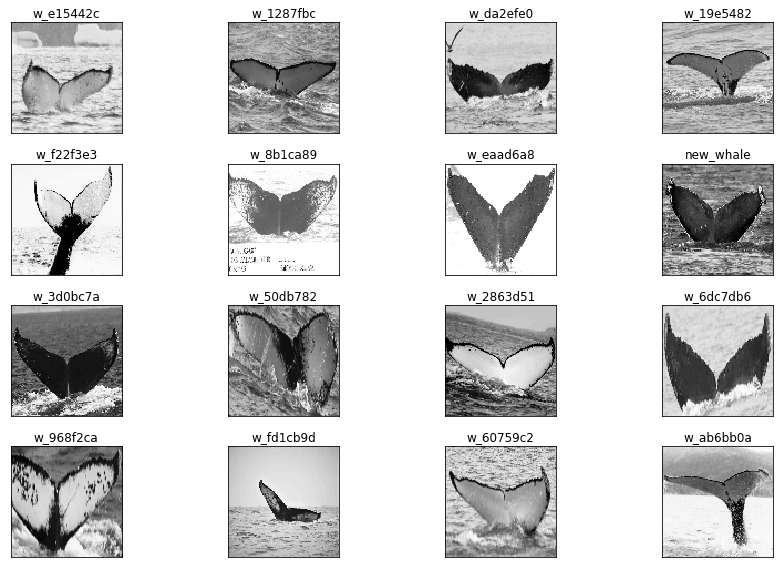

In [34]:
plotImages(x, df['Id'].tolist())

## Image augmentation with Keras

In [ ]:
# use of an image generator for preprocessing and data augmentation
x = x.reshape((-1, SIZE, SIZE, 1))
input_shape = x[0].shape
x_train = x.astype('float32')
y_train = y_cat

In [28]:
image_gen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True    
)
# training the image preprocessing
image_gen.fit(x_train, augment=True)


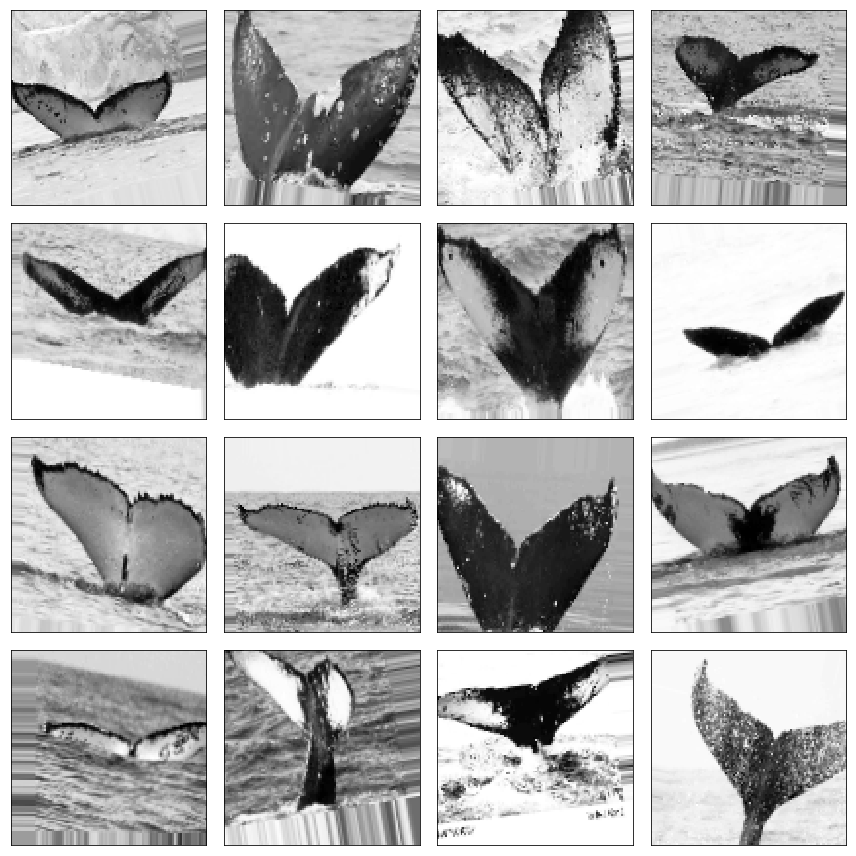

In [29]:
# visualization of some images out of the preprocessing
augmented_images, _ = next(image_gen.flow(x_train, y_train.toarray(), batch_size=4*4))
plotImages(augmented_images)

In [30]:
augmented_images.shape

(16, 100, 100, 1)

## Building and training model

In [34]:
batch_size = 128
num_classes = len(y_cat.toarray()[0])
epochs = x_train.shape[0]//batch_size + 1
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')


x_train shape: (9850, 100, 100, 1)
9850 train samples


In [ ]:
# model
model = Sequential()
model.add(Conv2D(48, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(48, kernel_size=(3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(48, kernel_size=(5, 5), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.33))
model.add(Flatten())
model.add(Dense(36, activation='sigmoid'))
model.add(Dropout(0.33))
model.add(Dense(36, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))


In [ ]:
isMultiGPU = 1
if isMultiGPU:
    parallel_model = multi_gpu_model(model, 2)
    parallel_model.compile(loss=keras.losses.categorical_crossentropy,
                           optimizer=keras.optimizers.Adadelta(),
                           metrics=['accuracy'])
else:
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
plot_model(model, to_file='whale_model_01.png')

In [ ]:
if isMultiGPU:
    parallel_model.fit_generator(image_gen.flow(x_train, y_train.toarray(), 
                                                batch_size=batch_size),
                                 steps_per_epoch=x_train.shape[0]//batch_size,
                                 epochs=epochs,
                                 shuffle=True,
                                 verbose=1,
                                 validation_data=(),
                                 class_weight=class_weight_dict)
else:
    model.fit_generator(image_gen.flow(x_train, y_train.toarray(), 
                                       batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        epochs=epochs,
                        verbose=1,
                        class_weight=class_weight_dict)

## Predictions on test samples and export for submission

In [ ]:
%%time
import warnings
import os

with open(str(main_path / 'submission.csv'), 'w') as f:
    with warnings.catch_warnings():
        f.write("Image,Id\n")
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        for img in test_image:
            tmp_img = ImportImage(img)
            x = tmp_img.astype('float32')
            x = image_gen.standardize(x.reshape(1, SIZE, SIZE))
            y = model.predict_proba(x.reshape(1, SIZE, SIZE, 1))        
            predicted_args = np.argsort(y)[0][::-1][:5]
            predicted_tags = lohe.inverse_labels(predicted_args)
            img = os.path.split(img)[-1]
            predicted_tags = " ".join(predicted_tags)
            f.write('%s,%s\n' %(img, predicted_tags))
            

